In [1]:
from exp_framework.Ensemble import Ensemble, PretrainedEnsemble
from exp_framework.delegation import (
    DelegationMechanism,
    UCBDelegationMechanism,
    ProbaSlopeDelegationMechanism,
)
from exp_framework.experiment import (
    Experiment,
    calculate_avg_std_test_accs,
    calculate_avg_std_train_accs,
    calculate_avg_std_test_accs_per_trial,
)
from matplotlib import pyplot as plt
from exp_framework.data_utils import Data
import numpy as np
import matplotlib as mpl
import seaborn as sns

from avalanche.benchmarks.classic import RotatedMNIST, SplitMNIST
# from avalanche.training.plugins import (
#     CWRStarPlugin,
#     ReplayPlugin,
#     EWCPlugin,
#     TrainGeneratorAfterExpPlugin,
#     LwFPlugin,
#     SynapticIntelligencePlugin,
# )
from avalanche.training import plugins as plg
from exp_framework.MinibatchEvalAccuracy import MinibatchEvalAccuracy
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics

from avalanche.training import EWC
from avalanche.training.supervised import Naive

import torch.optim as optim
from torch.nn import CrossEntropyLoss

from exp_framework.learning import Net

/Users/ben/VSCode/banditLiquidDem/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### learning the mapping $\mathcal{X} \rightarrow \mathcal{G}$ (i.e. $\mathcal{X} \rightarrow \mathcal{Y}\times\mathcal{C}$)

In [2]:
batch_size = 128
window_size = 55
# window_size = 55
num_trials = 10
n_voters = 5
width = 64

In [3]:
def initialize_strategies_to_evaluate():
    
    plugins_to_evaluate = {
        "AGEM": plg.AGEMPlugin(patterns_per_experience=50, sample_size=256),    # https://arxiv.org/pdf/1812.00420.pdf
        "CoPE": plg.CoPEPlugin(p_size=10),   # has default parameters in Avalanche
        "CWR": "LATER",    # mostly has default parameters (?)
        "EWC": plg.EWCPlugin(ewc_lambda=0.001),
        "GDumb": plg.GDumbPlugin(),
        "GEM": plg.GEMPlugin(patterns_per_experience=5120, memory_strength=0.5),  # https://arxiv.org/pdf/1706.08840.pdf
        # "GSS_greedy": plg.GSS_greedyPlugin(),
        "LFL": plg.LFLPlugin(lambda_e=0.0016),      # https://arxiv.org/pdf/1607.00122.pdf
        "LwF": plg.LwFPlugin(),
        "Replay": plg.ReplayPlugin(mem_size=100),
        "SynapticIntelligence": plg.SynapticIntelligencePlugin(si_lambda=0.5),
        "MAS": plg.MASPlugin(),
        "TrainGeneratorAfterExp": plg.TrainGeneratorAfterExpPlugin(),
        "RWalk": plg.RWalkPlugin(),
        # "GenerativeReplay": plg.GenerativeReplayPlugin()
        "BiC": plg.BiCPlugin(),
        "MIR": plg.MIRPlugin(batch_size_mem=10),
    }

    strategies_to_evaluate = {}
    for name, pte in plugins_to_evaluate.items():

        model = Net(input_dim=28 * 28, output_dim=10, width=5)
        if name == "CWR":
            strategies_to_evaluate["CWR"] = plg.CWRStarPlugin(model)
            pte = strategies_to_evaluate["CWR"]
        if name == "LFL":
            from avalanche.models import SimpleMLP
            model = SimpleMLP(num_classes=10, hidden_layers=2, hidden_size=width)
        optimize = optim.Adam(model.parameters(), lr=0.001)

        mb_eval = MinibatchEvalAccuracy()
        evp = EvaluationPlugin(
            accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
            mb_eval,
        )
        cl_strategy = Naive(
            model=model,
            optimizer=optimize,
            criterion=CrossEntropyLoss(),
            train_mb_size=batch_size,
            train_epochs=1,
            eval_mb_size=batch_size,
            # plugins=[pte, evp],
            plugins=[pte, evp, mb_eval],
        )
        # cl_strategy = EWC(
        #     model=model,
        #     optimizer=optimize,
        #     criterion=CrossEntropyLoss(),
        #     ewc_lambda=0.001,
        #     train_mb_size=batch_size,
        #     train_epochs=1,
        #     eval_mb_size=batch_size,
        # )
        strategies_to_evaluate[name] = (cl_strategy, evp)

    return strategies_to_evaluate

In [4]:
data = SplitMNIST(n_experiences=5, fixed_class_order=list(range(10)))

NOOP_del_mech = DelegationMechanism(batch_size=batch_size, window_size=window_size)

proba_slope_del_mech = ProbaSlopeDelegationMechanism(
    batch_size=batch_size, window_size=window_size
)

NOOP_del_mech2 = DelegationMechanism(batch_size=batch_size, window_size=window_size)

ensembles = [
    Ensemble(
        training_epochs=1,
        n_voters=n_voters,
        delegation_mechanism=NOOP_del_mech,
        name="full_ensemble",
        input_dim=28 * 28,
        output_dim=10,
        width=width,
    ),
    Ensemble(
        training_epochs=1,
        n_voters=n_voters,
        delegation_mechanism=proba_slope_del_mech,
        name="proba_slope_delegations",
        input_dim=28 * 28,
        output_dim=10,
        width=width,
    ),
    Ensemble(
        training_epochs=1,
        n_voters=1,
        delegation_mechanism=NOOP_del_mech2,
        name="single_learner",
        input_dim=28 * 28,
        output_dim=10,
        width=width,
    ),
]

exp = Experiment(
    n_trials=num_trials,
    ensembles=ensembles,
    benchmark=data,
    strategies_to_evaluate=initialize_strategies_to_evaluate,
)
_ = exp.run()

  0%|          | 0/10 [00:00<?, ?it/s]/Users/ben/VSCode/banditLiquidDem/.conda/lib/python3.10/site-packages/avalanche/training/plugins/cope.py:76: UserWarning: The current version of COPE is not working properly.Please, use it carefully. The performance may notbe aligned with the actual COPE performance.
  warnings.warn(
/Users/ben/VSCode/banditLiquidDem/.conda/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:68: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Starting trial  0
Training: AGEM!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:00<00:00, 189.50it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3592
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8971
-- >> End of training phase << --
Training: CoPE!
Using the Pseudo-Prototypical-Proxy loss for CoPE.
-- >> Start of training phase << --
  1%|          | 1/99 [00:00<00:01, 91.96it/s] 
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 44.2176
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0469
-- >> End of training phase << --
Training: CWR!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:00<00:00, 201.25it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3912
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9005
-- >> End of training phase << --
Training: EWC!
-- >> Start of training phase << --
100%|██████████| 99/99 [00:00<00:00, 192.57it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_s

  0%|          | 0/10 [00:20<?, ?it/s]


AttributeError: Can't pickle local object 'EmptyTransformGroups.__init__.<locals>.<lambda>'

In [ ]:
proba_slope_avg_test_accs, proba_slope_std_test_accs = calculate_avg_std_test_accs(
    exp, "proba_slope_delegations", num_trials
)
full_avg_test_accs, full_std_test_accs = calculate_avg_std_test_accs(
    exp, "full_ensemble", num_trials
)

(
    single_learner_avg_test_accs,
    single_learner_std_test_accs,
) = calculate_avg_std_test_accs(exp, "single_learner", num_trials)

(
    proba_slope_avg_test_accs_per_trial,
    proba_slope_std_test_accs_per_trial,
) = calculate_avg_std_test_accs_per_trial(exp, "proba_slope_delegations", num_trials)
(
    full_avg_test_accs_per_trial,
    full_std_test_accs_per_trial,
) = calculate_avg_std_test_accs_per_trial(exp, "full_ensemble", num_trials)

(
    single_learner_avg_test_accs_per_trial,
    single_learner_std_test_accs_per_trial,
) = calculate_avg_std_test_accs_per_trial(exp, "single_learner", num_trials)

In [ ]:
print(
    "Mean test accs for proba_slope delegation ensemble: ",
    np.mean(proba_slope_avg_test_accs),
)
print("Mean test accs for full ensemble: ", np.mean(full_avg_test_accs))

print("Mean test accs for single learner: ", np.mean(single_learner_avg_test_accs))

Mean test accs for proba_slope delegation ensemble:  0.338280188634526
Mean test accs for full ensemble:  0.19249193951487542
Mean test accs for single learner:  0.1568139826133847


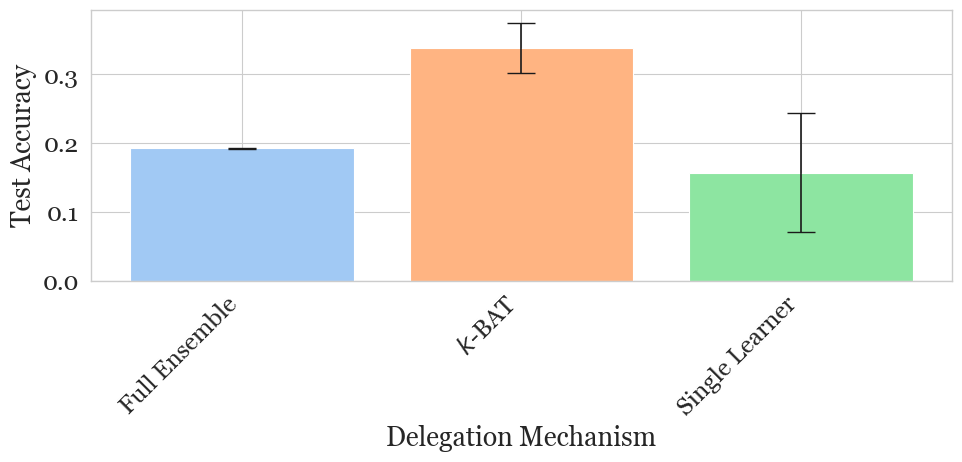

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Georgia"

# set colors for each bar. Use pastel
colors = sns.color_palette("pastel")
# assign colors for each bar

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
# ax.set_title("Test Accuracies")
ax.set_ylabel("Test Accuracy")
ax.set_xlabel("Delegation Mechanism")
# ax.set_xticks([0, 1, 2])
# ax.set_xticklabels(
#     ["No Delegation", "Proba Slope", "Restricted Max Guru"], rotation=45, ha="right"
# )
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(
    ["Full Ensemble", "$k$-BAT", "Single Learner"], rotation=45, ha="right"
)
# Data for bar plot
means = [
    np.mean(full_avg_test_accs_per_trial),
    np.mean(proba_slope_avg_test_accs_per_trial),
    np.mean(single_learner_avg_test_accs_per_trial),
]
stds = [
    np.std(full_avg_test_accs_per_trial),
    np.std(proba_slope_std_test_accs_per_trial),
    np.std(single_learner_std_test_accs_per_trial),
]

# Create each bar individually to set different colors
for i in range(len(ensembles)):
    ax.bar(i, means[i], color=colors[i], yerr=stds[i], capsize=10)

plt.tight_layout()
plt.show()

In [ ]:
proba_slope_avg_train_accs, proba_slope_std_train_accs = calculate_avg_std_train_accs(
    exp, "proba_slope_delegations", num_trials
)
full_avg_train_accs, full_std_train_accs = calculate_avg_std_train_accs(
    exp, "full_ensemble", num_trials
)

(
    single_learner_avg_train_accs,
    single_learner_std_train_accs,
) = calculate_avg_std_train_accs(exp, "single_learner", num_trials)

print(
    "Mean train accs for proba_slope delegation ensemble: ",
    np.mean(proba_slope_avg_train_accs),
)
print("Mean train accs for full ensemble: ", np.mean(full_avg_train_accs))

print("Mean train accs for single learner: ", np.mean(single_learner_avg_train_accs))

Mean train accs for proba_slope delegation ensemble:  0.866952805812698
Mean train accs for full ensemble:  0.8322824857164087
Mean train accs for single learner:  0.7557392129979064


In [ ]:
# get the trainsplits
train_splits = []
for experience in data.train_stream:
    print(experience.current_experience)
    print(len(experience.dataset))
    print(len(experience.dataset) / batch_size)
    # print the rounded number of batches (rounding up when remainder >0.5)
    print(np.round(len(experience.dataset) / batch_size))
    # append the cumulative sum of the number of batches
    if len(train_splits) == 0:
        train_splits.append(int(np.round(len(experience.dataset) / batch_size)))
    else:
        train_splits.append(
            int(train_splits[-1] + np.round(len(experience.dataset) / batch_size))
        )

print(train_splits)

0
12665
98.9453125
99.0
1
12089
94.4453125
94.0
2
11263
87.9921875
88.0
3
12183
95.1796875
95.0
4
11800
92.1875
92.0
[99, 193, 281, 376, 468]


((0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529))


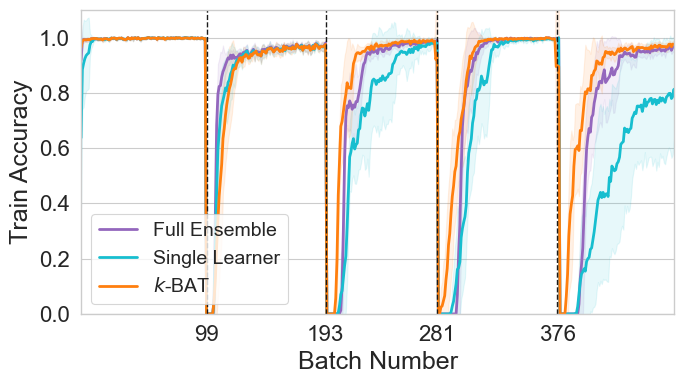

In [ ]:
sns.set(style="whitegrid", palette="pastel", context="paper")

# Set the font to Georgia
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["font.size"] = 12
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16

fig, ax = plt.subplots(figsize=(7, 4))

# colors = sns.color_palette("pastel")
# use the tabl10 color palette
colors = plt.get_cmap("tab10").colors

print(colors)


proba_slope_color = colors[1]
full_color = colors[4]
restricted_max_guru_color = colors[9]

alpha = 0.1
line_width = 2


ax.plot(full_avg_train_accs, label="Full Ensemble", color=full_color, linewidth=line_width)
ax.fill_between(
    range(len(full_avg_train_accs)),
    np.array(full_avg_train_accs) - np.array(full_std_train_accs),
    np.array(full_avg_train_accs) + np.array(full_std_train_accs),
    color=full_color,
    alpha=alpha,
)

ax.plot(
    single_learner_avg_train_accs,
    label="Single Learner",
    color=restricted_max_guru_color,
    linewidth=line_width,
)
ax.fill_between(
    range(len(single_learner_avg_train_accs)),
    np.array(single_learner_avg_train_accs) - np.array(single_learner_std_train_accs),
    np.array(single_learner_avg_train_accs) + np.array(single_learner_std_train_accs),
    color=restricted_max_guru_color,
    alpha=alpha,
)

ax.plot(
    proba_slope_avg_train_accs,
    label="$k$-BAT",
    color=proba_slope_color,
    linewidth=line_width,
)
ax.fill_between(
    range(len(proba_slope_avg_train_accs)),
    np.array(proba_slope_avg_train_accs) - np.array(proba_slope_std_train_accs),
    np.array(proba_slope_avg_train_accs) + np.array(proba_slope_std_train_accs),
    color=proba_slope_color,
    alpha=alpha,
)


# plot vertical lines at test splits
for split in train_splits[:-1]:
    ax.axvline(x=split, color="k", linestyle="--", linewidth=1)

# Setting labels, title, and legend
ax.set_xlabel("Batch Number")
ax.set_ylabel("Train Accuracy")
# ax.set_title("Train Accuracies for SWBA Delegation Ensemble and Full Ensemble")

# make x and y labels bigger
ax.set_xlabel("Batch Number", fontsize=18)
ax.set_ylabel("Train Accuracy", fontsize=18)

ax.legend(loc="lower left")
# set y lim to lower
# set y ticks to 0-1
ax.set_yticks(np.arange(0, 1.1, 0.1))

# set ylim
ax.set_ylim(0, 1.1)
# set xlim
ax.set_xlim(0, train_splits[-1])

# remove vertical gridlines
ax.yaxis.grid(True)
ax.xaxis.grid(False)

# set xticks to the train splits
ax.set_xticks(train_splits[:-1])
# set y ticks to 0-1
ax.set_yticks(np.arange(0, 1.1, 0.2))


# make xtick and ytick font bigger
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


# make legend font bigger
plt.legend(fontsize=14)

plt.tight_layout()

# Show the plot
plt.show()

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393), (1.0, 0.7058823529411765, 0.5098039215686274), (0.5529411764705883, 0.8980392156862745, 0.6313725490196078), (1.0, 0.6235294117647059, 0.6078431372549019), (0.8156862745098039, 0.7333333333333333, 1.0), (0.8705882352941177, 0.7333333333333333, 0.6078431372549019), (0.9803921568627451, 0.6901960784313725, 0.8941176470588236), (0.8117647058823529, 0.8117647058823529, 0.8117647058823529), (1.0, 0.996078431372549, 0.6392156862745098), (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]


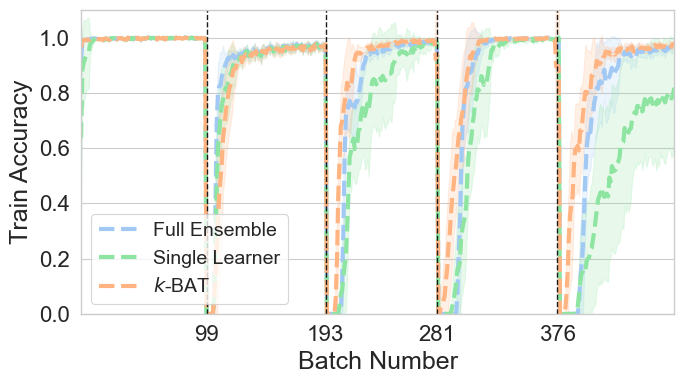

In [ ]:
sns.set(style="whitegrid", palette="pastel", context="paper")

# Set the font to Georgia
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["font.size"] = 12
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16

fig, ax = plt.subplots(figsize=(7, 4))

colors = sns.color_palette("pastel")
# use the tabl10 color palette
# colors = plt.get_cmap("tab10").colors

print(colors)


proba_slope_color = colors[1]
full_color = colors[0]
restricted_max_guru_color = colors[2]

alpha = 0.2
line_width = 3
#dashed line
line_style = "--"


ax.plot(full_avg_train_accs, label="Full Ensemble", color=full_color, linewidth=line_width, linestyle=line_style)
ax.fill_between(
    range(len(full_avg_train_accs)),
    np.array(full_avg_train_accs) - np.array(full_std_train_accs),
    np.array(full_avg_train_accs) + np.array(full_std_train_accs),
    color=full_color,
    alpha=alpha,
)

ax.plot(
    single_learner_avg_train_accs,
    label="Single Learner",
    color=restricted_max_guru_color,
    linewidth=line_width,
    linestyle=line_style,
)
ax.fill_between(
    range(len(single_learner_avg_train_accs)),
    np.array(single_learner_avg_train_accs) - np.array(single_learner_std_train_accs),
    np.array(single_learner_avg_train_accs) + np.array(single_learner_std_train_accs),
    color=restricted_max_guru_color,
    alpha=alpha,
)

ax.plot(
    proba_slope_avg_train_accs,
    label="$k$-BAT",
    color=proba_slope_color,
    linewidth=line_width,
    linestyle=line_style,
)
ax.fill_between(
    range(len(proba_slope_avg_train_accs)),
    np.array(proba_slope_avg_train_accs) - np.array(proba_slope_std_train_accs),
    np.array(proba_slope_avg_train_accs) + np.array(proba_slope_std_train_accs),
    color=proba_slope_color,
    alpha=alpha,
)


# plot vertical lines at test splits
for split in train_splits[:-1]:
    ax.axvline(x=split, color="k", linestyle="--", linewidth=1)

# Setting labels, title, and legend
ax.set_xlabel("Batch Number")
ax.set_ylabel("Train Accuracy")
# ax.set_title("Train Accuracies for SWBA Delegation Ensemble and Full Ensemble")

# make x and y labels bigger
ax.set_xlabel("Batch Number", fontsize=18)
ax.set_ylabel("Train Accuracy", fontsize=18)

ax.legend(loc="lower left")
# set y lim to lower
# set y ticks to 0-1
ax.set_yticks(np.arange(0, 1.1, 0.1))

# set ylim
ax.set_ylim(0, 1.1)
# set xlim
ax.set_xlim(0, train_splits[-1])

# remove vertical gridlines
ax.yaxis.grid(True)
ax.xaxis.grid(False)

# set xticks to the train splits
ax.set_xticks(train_splits[:-1])
# set y ticks to 0-1
ax.set_yticks(np.arange(0, 1.1, 0.2))


# make xtick and ytick font bigger
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


# make legend font bigger
plt.legend(fontsize=14)

plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
ps_voters = exp.ensembles[1].voters
print(ensembles[1].name)
batch_accs = []
for v in ps_voters:
    batch_accs.append(v.batch_accuracies)

proba_slope_delegations


In [ ]:
len_train = train_splits[-1]
print(len_train)

468


In [ ]:
def find_active_streaks(voter_id, trial_num):
    """
    Find active streaks for a specified voter.

    :param voter_id: ID of the voter for which to find active streaks.
    :param batch_metric_values: Dictionary containing the batch metric values.
    :param metric_key: Key to access the relevant metric in batch_metric_values.
    :return: List of active streaks for the specified voter.
    """
    active_batches = []
    active_streak = [None, None]
    voter_active = False

    for i, av in enumerate(
        exp.batch_metric_values["proba_slope_delegations"][trial_num][
            "active_voters-train"
        ]
    ):
        # print(av)
        if voter_id in av:
            if not voter_active:
                # Start a new streak
                active_streak[0] = i
                voter_active = True
                # print("streak started")
            active_streak[1] = i
        else:
            if voter_active:
                # End the current streak
                active_batches.append(active_streak.copy())
                active_streak = [None, None]
                voter_active = False
                # print("streak done")

    # Handle case where the streak continues till the end of the list
    if voter_active:
        active_batches.append(active_streak.copy())

    return active_batches

### Look at activity on last trial

In [ ]:
# for voter_id in range(n_voters):
#     active_streaks = find_active_streaks(voter_id, num_trials - 1)
#     # print(f"Active Streaks for Voter {voter_id}: {active_streaks}")

#     plt.figure(figsize=(10, 5))  # Create a new figure for each voter
#     plt.plot(batch_accs[voter_id])
#     plt.axvline(x=len_train, color="k", linestyle="--", linewidth=1)

#     # Shade the active batches for this voter
#     for streak in active_streaks:
#         if streak[0] is not None and streak[1] is not None:
#             plt.axvspan(streak[0], streak[1], alpha=0.3, color="red")

#     # Plot a green vertical line at all train splits
#     for split in train_splits[:-1]:
#         plt.axvline(x=split, color="g", linestyle="--", linewidth=2)

#     plt.title(f"Voter {voter_id+1} Activity")
#     plt.xlabel("Batches")
#     plt.ylabel("Accuracy")
#     plt.show()  # Display the plot for each voter

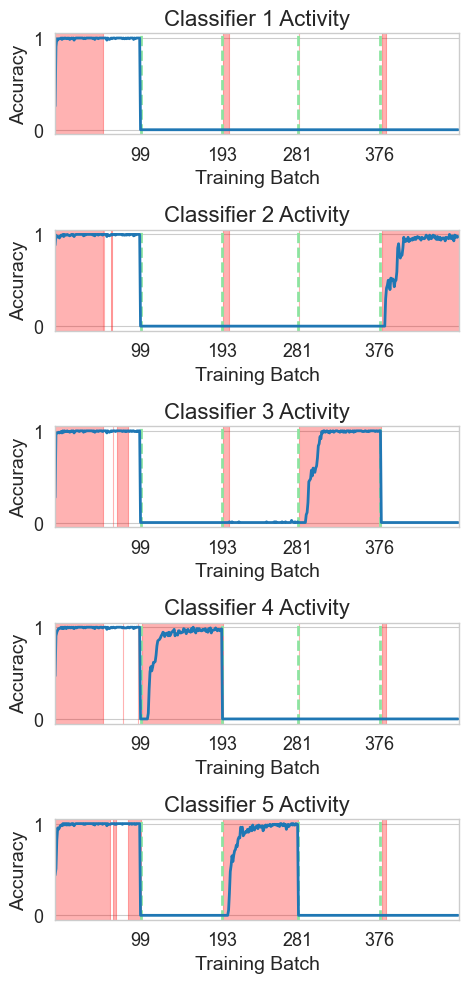

In [ ]:
# import patches
import matplotlib.patches as patches

fig, axes = plt.subplots(
    n_voters, 1, figsize=(5, 2 * n_voters)
)  # Adjust the figure size as needed

for voter_id in range(n_voters):
    active_streaks = find_active_streaks(voter_id, num_trials - 1)
    ax = axes[voter_id]  # Get the current axis

    # Plot a green vertical line at all train splits
    for split in train_splits[:-1]:
        ax.axvline(x=split, color="g", linestyle="--", linewidth=2)

    ax.plot(batch_accs[voter_id][: train_splits[-1]], color="tab:blue", linewidth=2)
    # ax.axvline(x=len_train, color="k", linestyle="--", linewidth=1)

    # Shade the active batches for this voter
    for streak in active_streaks:
        if streak[0] is not None and streak[1] is not None:
            ax.axvspan(streak[0], streak[1], alpha=0.3, color="red")

    ax.set_title(f"Classifier {voter_id+1} Activity")

    # make xlim to the last train split
    ax.set_xlim(0, train_splits[-1])

    ax.set_xlabel("Training Batch")
    # make

    ax.set_ylabel("Accuracy")

    # make the xtick and ytick font bigger
    ax.tick_params(axis="x", labelsize=13)
    ax.tick_params(axis="y", labelsize=13)

    # set xticks to the train splits
    ax.set_xticks(train_splits[:-1])

    # remove vertical gridlines
    ax.yaxis.grid(True)
    ax.xaxis.grid(False)


plt.tight_layout()
plt.show()  # Display all plots at once